#### Imports


In [171]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

#### Definitions

We define the discrete gradient operator $D$ and its adjoint $D^*$.

In [172]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [173]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

We regularize the strongly convex primal problem by adding the corresponding LASSO term :
$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= f(x)+ g(Dx) + \alpha \lVert x \rVert_{1} =\frac{1}{2}\|x-y\|^2+\lambda\|Dx\|_{1,2} + \alpha \lVert Dx \rVert_{1}$$


Which is equivalent to

$$\min_{x \in \R^{N_1\times N_2}} E_p(x)= \frac{1}{2}\|x-y\|^2+ h(Dx)$$

Where :

$$ h(x) = f(x) + g(x) $$
$$ f(x) = \lambda\|x\|_{1,2}  $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

Therefore, we have to adapt the proximal operator for $h$, knowing that :

$$ x = \text{prox}_{\gamma h^*}(x) + \gamma \text{prox}_{h/\gamma}(x/\gamma) $$

Moreover, we will first assume that

$$ \text{prox}_{\gamma h}(x) =  \text{prox}_{\gamma g}(x) \circ \text{prox}_{\gamma f}(x)  $$

Thus yielding


$$\begin{aligned}

\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) \\
= u - \gamma \text{prox}_{g / \gamma}(\text{prox}_{f / \gamma}(u/\gamma) ) 
\end{aligned}$$

With

$$\text{prox}_{g/\gamma}(u) = \text{defined numerically, or by } \ \text{sign}(u) \cdot max\{0;|u| - \alpha/\gamma\} $$

Regarding $\text{prox}_{f/\gamma}(u/\gamma)$, we know that for $f(x) =  \lambda \ \lVert x \rVert_{1,2} $, we have 

$$\big(\text{prox}_{\gamma f^*}(u)\big)_{n_1,n_2}=\frac{1}{\max(\|u_{n_1,n_2}\|_2/\lambda,1)}u_{n_1,n_2}\in\mathbb{R}^2,\quad\forall (n_1,n_2).$$ 

Using the Moreau identity once again, and in the context of our newly defined problem, we can write 

$$

 \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \big(\text{prox}_{\gamma f^*}(u)\big) 
$$


$$
\Rightarrow \text{prox}_{f/\gamma}(u/\gamma) = \frac{u - \big(\text{prox}_{\gamma f^*}(u)\big)}{\gamma} 
$$

Knowing that $\big(\text{prox}_{\gamma f^*}(u)\big)$ is implemented as :


In [174]:
def prox_f_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

We can implement this proximal operator as :

In [175]:
def proximal_TV_operator(u,gamma,Lambda) : 
    return( (u - prox_f_conj(u,Lambda)) / gamma)

#def proximal_TV_operator(x, gamma, Lambda):
#    """  
#    Applies the proximal operator of the TV term.
#    
#    Parameters
#    ----------
#    x : Multidim. array to which we apply the proximal operator. (np.ndarray)
#    gamma : The usual gamma term (float)
#    Lambda : Multiplicative coefficient of the TV term (float)
#
#    Returns 
#    ---------
#    prox_result : The resulting ndarray from the application of the "TV" proximal operator.
#
#    """
#    #Defining the TV operator (that's how pyproximal works apparently)
#    TV = pyproximal.TV(dims=x.shape, sigma=Lambda)
#    try:
#        #Apply the TV proximal operator to x/gamma, and reshape the result to what we need
#        prox_result = TV.prox((x / gamma),2).reshape((512,512,2))
#        #print(f"TV.prox result shape: {result.shape}")
#        return prox_result
#    except Exception as e:
#        print(f"Error in TV.prox: {e}")
#        raise

For the proximal operator of $g$, we can implement it as :

In [176]:
def proximal_operator_lasso(u, alpha,gamma):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to u, scaled by 1/gamma, then reshape the result to what we need
        prox_result = L1.prox(u,1/gamma).reshape((512,512,2))
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

We can then add both into the proximal operator of $h$ :

In [177]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:
        #Application of the proximal 'TV' operator...
        prox_tv = proximal_TV_operator(redef_u, gamma, Lambda)
        #... And successive application of the proximal 'lasso' operator
        prox_lasso = proximal_operator_lasso(prox_tv, alpha, gamma)
        proximal_composition = gamma * prox_lasso

        return redef_u - proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

## The original Chambolle algorithm

In the original implementation of the Chambolle algorithm the unisotropic term doesn't appear and the implementation is therefore much simpler :

In [ ]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


## Implementation of revised algorithm

We then implement this newly defined proximal operator into Chambolle's algorithm. As previously explained, the implementation stays the same, besides the computation of $u^{(k+1)}$, which is now defined as a composition of operators.

In [178]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


## Comparisons of the algorithms on the baseline Lena image.

To compare the original Chambolle algorithm with our revised version of the latter, we will first use the baseline Lena image from the `scipy.misc` package. This image represents two people walking up a wooden structure.

The code below generates the image and its noised version, generated following the theory on image denoising, i.e assuming that the nature of this noise is white gaussian.

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\2194654800.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


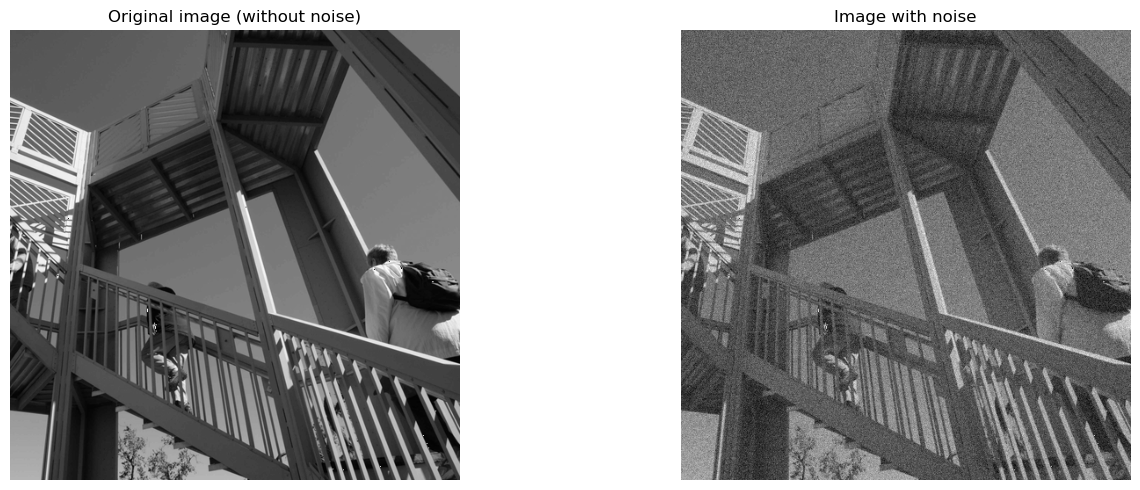

In [183]:
'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
noiselevel = 20
noised_image = xsharp + noiselevel * np.random.randn(N1,N2)

# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

We will now compare the two implementations at our disposal in the case of this image. Using the parameters $\lambda = 25, \gamma= \frac{1.9}{8}$ and $\alpha = 20$ as a first try, we run :
- The original Chambolle once
- The revised Chambolle twice : Once with $\alpha=0$ and the second with $\alpha=10$. This is done to check that the case $\alpha=0$ indeed yields the same results as the original Chambolle.

In [237]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 20

original_denoised_image,original_ep_array,original_ed_array  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)
denoised_image_nolasso,alphazero_ep_array,alphazero_ed_array  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,alpha_ep_array,alpha_ed_array = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

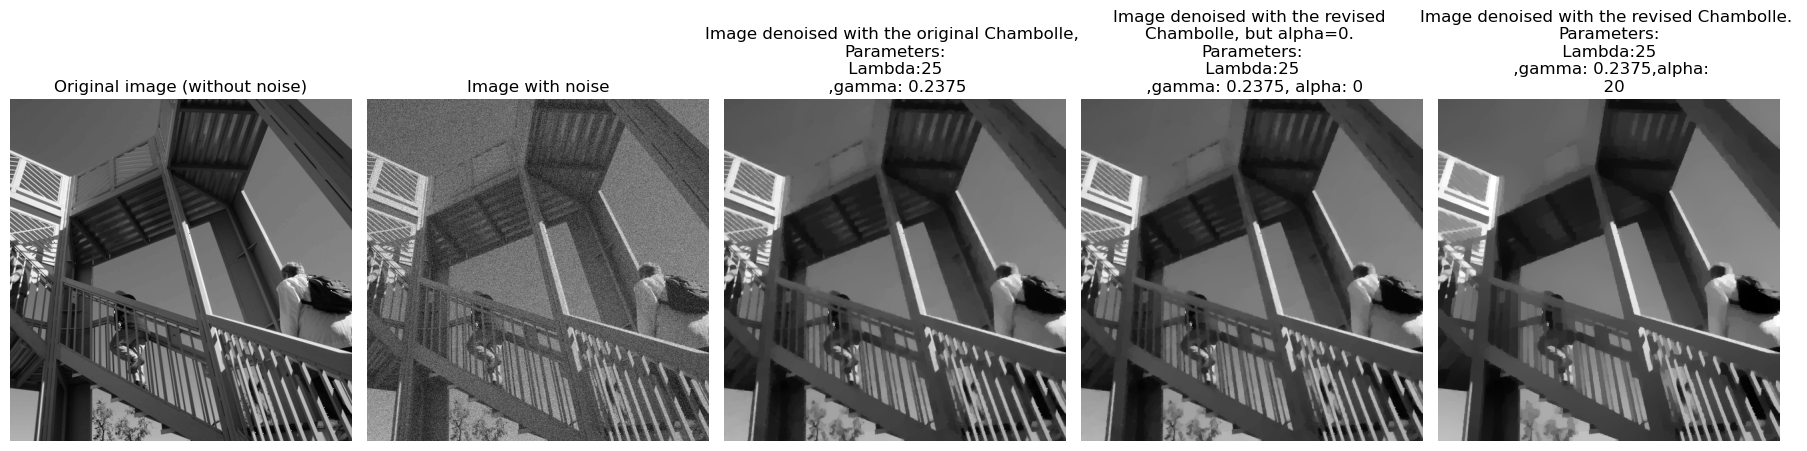

In [238]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")


# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

The images 3 & 4 (from left to right) above seem to indicate that our revised implementation of Chambolle's algorithm with $\alpha= 0$ and the original Chambolle lead to the same denoised image. Moreover, we can see that adding the $\alpha$ parameter and thus, the new term we added in our primal problem, have an impact on the denoising result. Namely, from what we can see here,  the image is a bit more blurred, due to what seems like a smoothing of the different textures. 

##### Are the original Chambolle and revised Chambolle with $\alpha=0$ the same?

Keeping the investigation on the exact importance of the $\alpha$ parameter for later, let us first focus on comparing our $\alpha = 0$ setting to the original Chambolle. More specifically, let us take a look at the Primal and Dual energies resulting from the iterations :

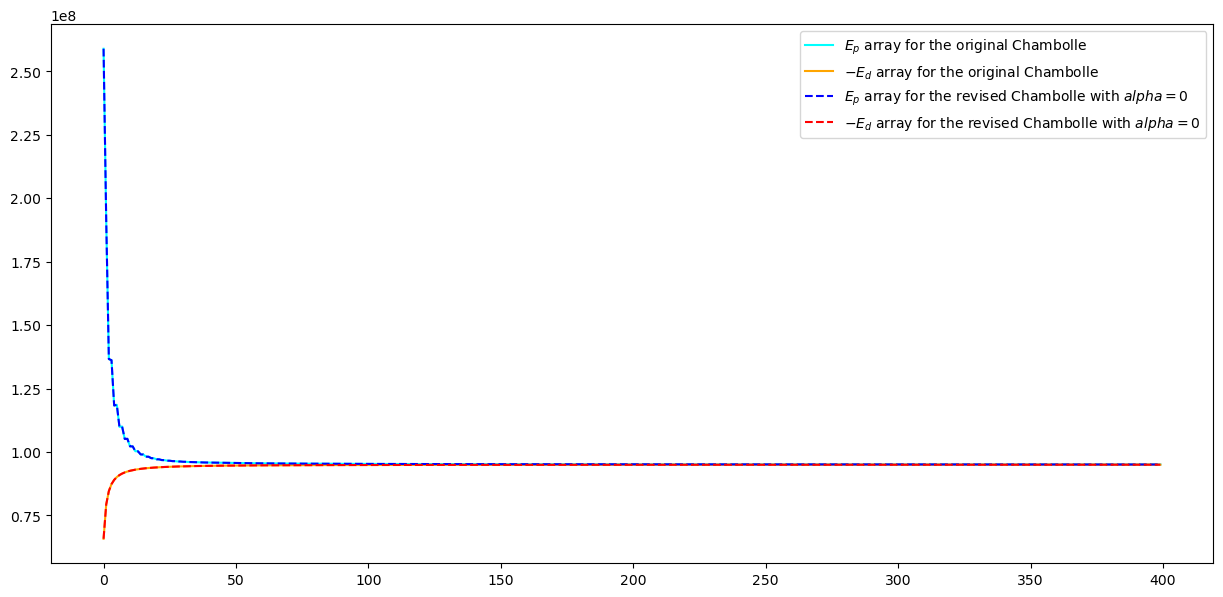

In [239]:
plt.figure(figsize=(15,7))

plt.plot(original_ep_array, color='cyan', label='$E_p$ array for the original Chambolle')
plt.plot(-original_ed_array, color='orange', label='$-E_d$ array for the original Chambolle')

plt.plot(alphazero_ep_array, color='b', linestyle='--', label='$E_p$ array for the revised Chambolle with $alpha=0$')
plt.plot(-alphazero_ed_array, color='r', linestyle='--', label='$-E_d$ array for the revised Chambolle with $alpha=0$')
plt.legend()

plt.show()

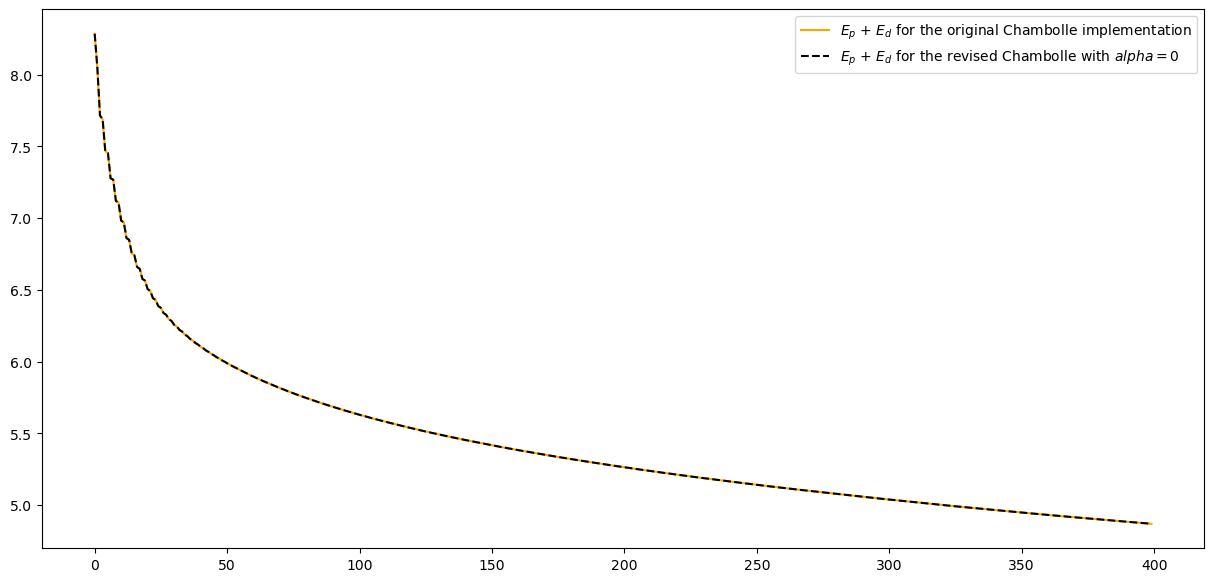

In [240]:
plt.figure(figsize=(15,7))
plt.plot(np.log10(original_ep_array+original_ed_array),color='orange', label='$E_p$ + $E_d$ for the original Chambolle implementation')
plt.plot(np.log10(alphazero_ep_array+alphazero_ed_array),color='black', linestyle='--', label='$E_p$ + $E_d$ for the revised Chambolle with $alpha=0$')
plt.legend()

plt.show()

We indeed obtain the exact same steps throughout the iterations : the two methods are equal. Does this change anything with respect to the Signal To Noise Ratio (SNR)?

In [241]:
def calculate_psnr(img1, img2, max_value=255):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

noisy_image_psnr = calculate_psnr(xsharp, noised_image)
original_chambolle_psnr = calculate_psnr(xsharp, original_denoised_image)
alphazero_psnr = calculate_psnr(xsharp, denoised_image_nolasso)

print("PSNR of the noisy image:", noisy_image_psnr)
print("PSNR for original Chambolle:", original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", alphazero_psnr)


PSNR of the noisy image: 22.117192818771873
PSNR for original Chambolle: 28.001671613450142
PSNR for revised version with alpha = 0 : 28.001671613450142


The images we obtain after denoising are the exact same. This means that our revised algorithm is most likely correctly implemented ! 

#### Investigating the effect of the addition of the anisotropic term (to our objective primal function) to the denoising problem.

In the case of dummy values for our different parameters, on the Lena image, we saw a blur/smoothing induced by the introduction of the anisotropic term. 

With  $\alpha = 0$, i.e original Chambolle, we can see that the denoising is already improving sensitively the PSNR from the noised image. What about with $\alpha = 40$ (the parameter set earlier when generating the images ?)

In [242]:
alpha_psnr = calculate_psnr(xsharp, denoised_image_lasso)

print("PSNR of the image denoised with the revised Chambolle and alpha = 20:", alpha_psnr)

PSNR of the image denoised with the revised Chambolle and alpha = 20: 25.021937405680305


PSNR confirms what can be seen in the image : doesn't improve much the visibility with the added blur, neither does it improve PSNR by much. The original Chambolle performs better than our newly revised algorithm in this specific dummy setup. This can lead to the hypothesis that, original Chambolle is 'enough' for the image generated and its level of noise. We can thus ask ourselves what happens when the image is noisier than what it is now ?

In [254]:
new_noiselevel = 45
alpha= 20
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400

noisier_image = xsharp + new_noiselevel * np.random.randn(N1,N2)

original_noisier_denoised_image,_,_  = original_chambolle_algorithm(noisier_image,Lambda,gamma,nbiter)
denoised_noisier_image_nolasso,_,_  = chambolle_algorithm(noisier_image,Lambda,gamma,0,nbiter)
denoised_noisier_image_lasso,_,_ = chambolle_algorithm(noisier_image,Lambda,gamma,20,nbiter)

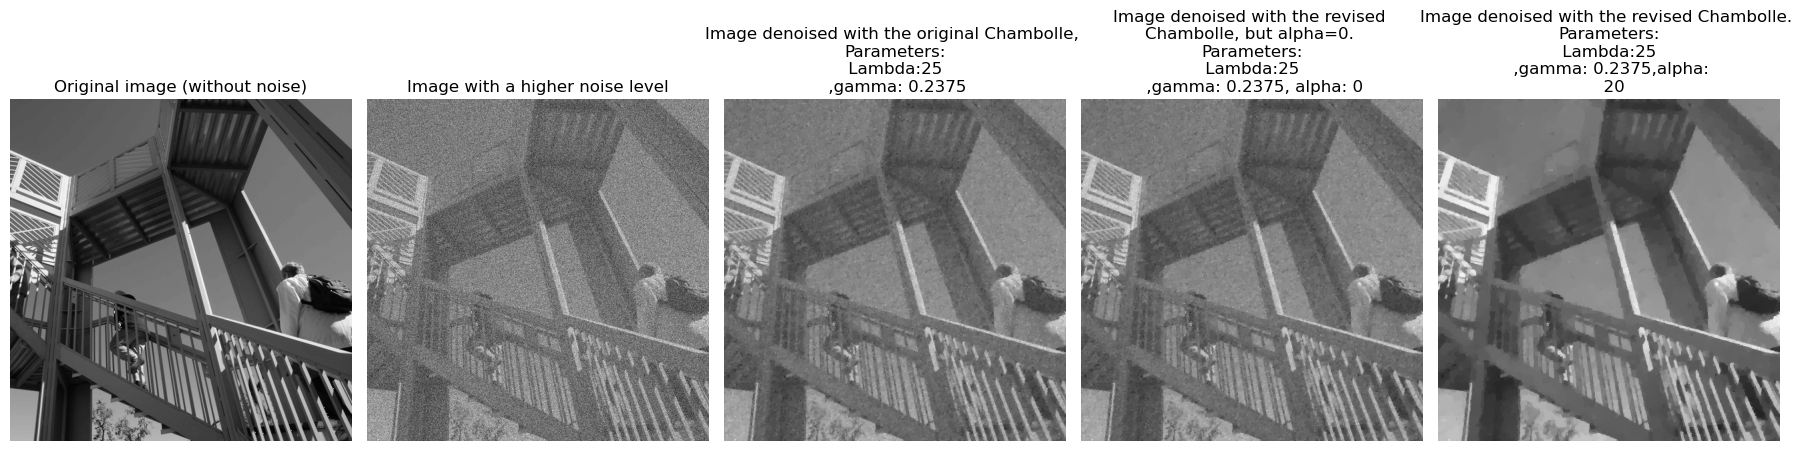

PSNR of the noisy image: 15.059823104475312
PSNR for original Chambolle: 23.885467532711488
PSNR for revised version with alpha = 0 : 23.885467532711488
PSNR of the image denoised with the revised Chambolle and alpha = 20: 24.82481469627391


In [255]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noisier_image, cmap='gray')
axs[1].set_title('Image with a higher noise level')

axs[2].imshow(original_noisier_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")

axs[3].imshow(denoised_noisier_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[4].imshow(denoised_noisier_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")


# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

noisier_image_psnr = calculate_psnr(xsharp, noisier_image)
noisier_original_chambolle_psnr = calculate_psnr(xsharp, original_noisier_denoised_image)
noisier_alphazero_psnr = calculate_psnr(xsharp, denoised_noisier_image_nolasso)
noisier_alpha_psnr = calculate_psnr(xsharp, denoised_noisier_image_lasso)

print("PSNR of the noisy image:", noisier_image_psnr)
print("PSNR for original Chambolle:", noisier_original_chambolle_psnr)
print("PSNR for revised version with alpha = 0 :", noisier_alphazero_psnr)
print("PSNR of the image denoised with the revised Chambolle and alpha = 20:", noisier_alpha_psnr)

-----------

#### Additional : Trying to revert the composition of proximal operators

Here we implement the exact same algorithm as before, with the sole exception of modifying the composition of proximal operators in the Chambolle algorithm iterations. This means that, with


$$ f(x) = \lambda\|x\|_{1,2} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

We obtain :

$$\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) = u - \gamma \text{prox}_{f / \gamma}(\text{prox}_{g / \gamma}(u/\gamma) ).$$

To decipher this composition of proximal iterators, we need $\text{prox}_{\gamma f^*}(u)$ to appear, as it is the one we have. Using the Moreau decomposition once more, we can write


$$ \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \text{prox}_{f^*}(u)
$$ 

By then setting $v = \frac{u}{\gamma}$, we obtain

$$ \gamma \text{prox}_{f/\gamma}(v) = \gamma v - \text{prox}_{f^*}(\gamma v)
$$ 

We thus obtain, by replacing $v$ with $\text{prox}_{g / \gamma}(u/\gamma)$


$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u - ( \gamma\text{prox}_{g / \gamma}(u/\gamma) - \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma))) $$

$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u -  \gamma\text{prox}_{g / \gamma}(u/\gamma) + \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma)) $$



In [129]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:

        prox_lasso = proximal_operator_lasso(redef_u/gamma, alpha,gamma)

        proximal_composition = prox_f_conj(gamma*prox_lasso,Lambda)

        return redef_u - gamma*prox_lasso + proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise

In [224]:
#def complete_proximal_operator(u, x, gamma, Lambda, alpha):
#    redef_u = u + gamma * D(x)
#    
#    L21_plus_L1 = pyproximal.L21_plus_L1(sigma=1/(alpha+Lambda),rho=(Lambda/(alpha+Lambda)))
#    try:
#        
#        prox_result = gamma * L21_plus_L1.prox((redef_u / gamma),1/gamma).reshape((512,512,2))
#    
#        return redef_u - prox_result
#    except Exception as e:
#        print(f"Error in complete.prox: {e}")
#        raise

In [166]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

revert_denoised_image_nolasso,_,_  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
revert_denoised_image_lasso,_,_ = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)

c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:48: RuntimeWarning: invalid value encountered in divide
  l21 = np.maximum(1 - thresh * (1 - self.rho) / aux_l21, 0)
c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:49: RuntimeWarning: invalid value encountered in divide
  x = np.nan_to_num(x / np.abs(x)) * l1 * l21
c:\Users\dryha\anaconda3\envs\new-ml-proj-2\lib\site-packages\pyproximal\proximal\L21_plus_L1.py:48: RuntimeWarning: divide by zero encountered in divide
  l21 = np.maximum(1 - thresh * (1 - self.rho) / aux_l21, 0)


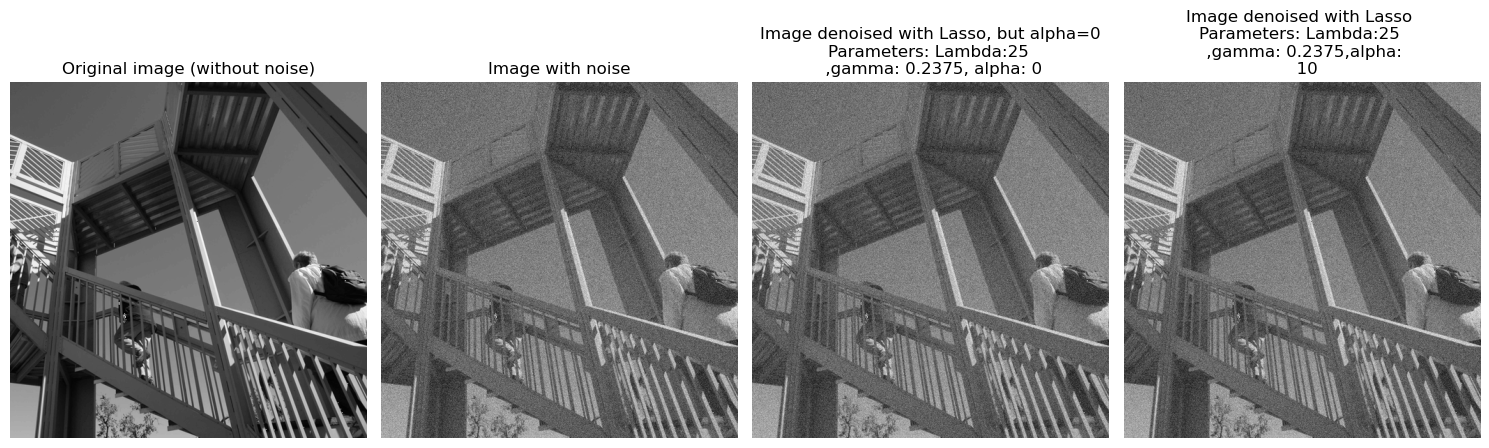

In [167]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(revert_denoised_image_nolasso, cmap='gray')
axs[2].set_title(f"Image denoised with Lasso, but alpha=0\nParameters: Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")

axs[3].imshow(revert_denoised_image_lasso, cmap='gray')
axs[3].set_title(f"Image denoised with Lasso \nParameters: Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#### Trying to optimize hyperparameters

In [111]:
#from sklearn.model_selection import ParameterGrid
#from skimage.metrics import peak_signal_noise_ratio as psnr
#
#
#Lambda_values = np.linspace(10, 100, 10)  
#gamma_values = np.linspace(0.1, 1.9/8, 10)  
#alpha_values = np.linspace(0, 100, 10)  
#
#param_grid = {
#    'Lambda': Lambda_values,
#    'gamma': gamma_values,
#    'alpha': alpha_values,
#}
#
#param_combinations = list(ParameterGrid(param_grid))
#
#best_psnr = -np.inf
#best_params = None
#best_xdenoised = None
#
#psnr_values = []
#
#for params in param_combinations:
#    Lambda = params['Lambda']
#    gamma = params['gamma']
#    alpha = params['alpha']
#
#    xdenoised, Ep_array, Ed_array = chambolle_algorithm(noised_image, Lambda, gamma, alpha, nbiter, homemade=True)
#    
#    # Assuming `original_image` is the ground truth image without noise
#    #print(xdenoised,xsharp)
#    current_psnr = psnr(xsharp, xdenoised,data_range=255)
#    psnr_values.append((Lambda, gamma, alpha, current_psnr))
#    
#    if current_psnr > best_psnr:
#        best_psnr = current_psnr
#        best_params = params
#        best_xdenoised = xdenoised
#
#print(f"Best Parameters: {best_params}")
#print(f"Best PSNR: {best_psnr}")
#
## Visualize the best denoised image
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(9,9))
#plt.imshow(best_xdenoised, cmap='gray')
#plt.title(f"Best Denoised Image\nParameters: {best_params}")
#plt.show()
#
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#
## Unpack psnr values for plotting
#Lambda_vals, gamma_vals, alpha_vals, psnr_vals = zip(*psnr_values)
#
#sc = ax.scatter(Lambda_vals, gamma_vals, alpha_vals, c=psnr_vals, cmap='viridis')
#ax.set_xlabel('Lambda')
#ax.set_ylabel('gamma')
#ax.set_zlabel('alpha')
#plt.colorbar(sc, label='PSNR')
#plt.title('PSNR for different parameter combinations')
#plt.show()

### Comparing performances with the original Chambolle algorithm

In the original implementation of the Chambolle algorithm the unisotropic term doesn't appear and the implementation is therefore much simpler :

In [140]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) # array for the primal energy E_p
    Ed_array = np.zeros(nbiter) # array for the dual energy E_d

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


In [144]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400

original_denoised_image,_,_  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)

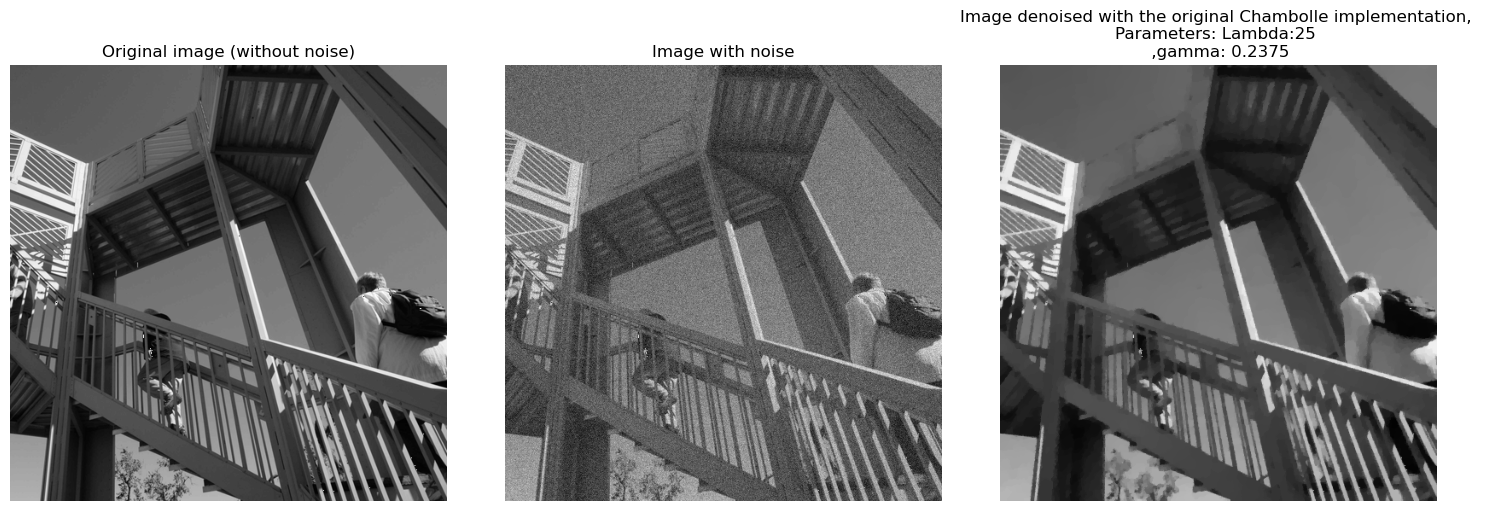

In [145]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')

axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle implementation, \nParameters: Lambda:{Lambda} \n ,gamma: {gamma}")

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()